# Image binary classification project:
## The project goal is to create a convolutional deep neaural network model to decide wheather an image is a cloth or home decoration through dataset of photos brought from Slash application.

## 1- Importing necessary libraries

In [76]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 2- Loading dataset and Removing any corrupted photos

In [78]:
photos_dir = 'photos'

In [79]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [80]:
#Removing any unreadable photo
for image_class in os.listdir(photos_dir): 
    for image in os.listdir(os.path.join(photos_dir, image_class)):
        image_path = os.path.join(photos_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

## 3- Classifying the datasets into two classes using keras:

In [81]:
#labelling photos into two classes 0s and 1s
#photos are divided into 8 batches with each batch size is equal to 32 photos
photos = tf.keras.utils.image_dataset_from_directory('photos')

Found 243 files belonging to 2 classes.


In [82]:
photos_iterator = photos.as_numpy_iterator()

In [83]:
#Images represented as numpy arrays in batch[0] and in batch[1] are the labels
batch = photos_iterator.next()

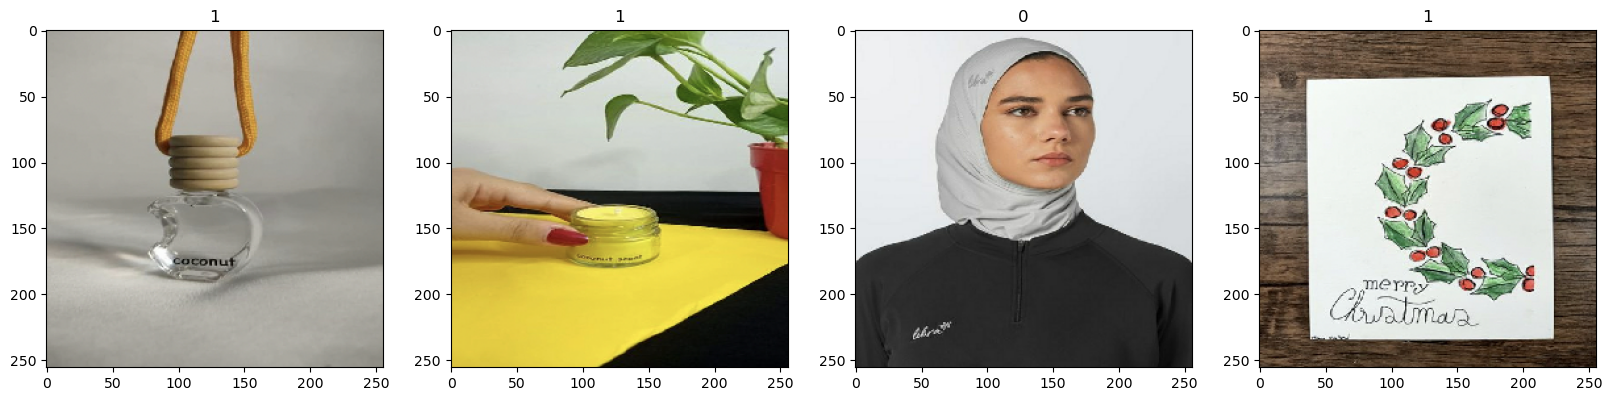

In [84]:

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Label 1 is for home decorations and label 0 is for clothes

## 4- Scaling the data

In [85]:
#scale the photos from 0 to 1
photos = photos.map(lambda x,y: (x/255, y))

In [86]:
photos.as_numpy_iterator().next()

(array([[[[0.76814705, 0.654902  , 0.56066525],
          [0.7720178 , 0.6543707 , 0.55615747],
          [0.76002043, 0.6529432 , 0.5572498 ],
          ...,
          [0.4374234 , 0.59786665, 0.9505535 ],
          [0.42396384, 0.5996679 , 0.96445096],
          [0.41956535, 0.5921485 , 0.9646293 ]],
 
         [[0.76722914, 0.6521654 , 0.5580478 ],
          [0.7620711 , 0.64705884, 0.5529412 ],
          [0.7611919 , 0.6485019 , 0.55438423],
          ...,
          [0.43423104, 0.594761  , 0.94481605],
          [0.41854906, 0.59698284, 0.956739  ],
          [0.415712  , 0.58820957, 0.9659424 ]],
 
         [[0.76593745, 0.6519281 , 0.55693936],
          [0.76357543, 0.65209866, 0.557981  ],
          [0.7719925 , 0.654519  , 0.5604013 ],
          ...,
          [0.43975675, 0.5977174 , 0.93460476],
          [0.42464766, 0.59311897, 0.961443  ],
          [0.41956595, 0.59202105, 0.9705698 ]],
 
         ...,
 
         [[0.44489688, 0.41174737, 0.3693454 ],
          [0.43172

In [87]:
#photos made of 8 batches each batch has 32 images
len(photos)

8

## 5- Splitting the data

In [88]:
train_size = int(len(photos)*.7)
val_size = int(len(photos)*.2)+1
test_size = int(len(photos)*.1)+1

In [89]:
#Ensure all batches are distributed
len(photos)==train_size+val_size+test_size

True

In [90]:
train = photos.take(train_size)
val = photos.skip(train_size).take(val_size)
test = photos.skip(train_size+val_size).take(test_size)

## 6- Building a Sequential deep learning model by 2D convolution

In [91]:
#make sequential deep learning model as no multiple inputs/outputs there
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [92]:
model = Sequential()

Adding layers to the neural network anf condensing it:

In [93]:
#Relu activation function is used to remove negatice values making the model non-linear
#sigmoid activation function is used to define the final output into 0s and 1s 
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [94]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [95]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

## 7- Training and validating the model 

In [96]:
historydir='history'

In [97]:
#To trace the training model
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=historydir)

In [98]:
tmodel= model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 464ms/step - accuracy: 0.5821 - loss: 0.9827 - val_accuracy: 0.6875 - val_loss: 0.5549
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 431ms/step - accuracy: 0.6371 - loss: 0.6251 - val_accuracy: 0.8594 - val_loss: 0.5260
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step - accuracy: 0.8579 - loss: 0.5156 - val_accuracy: 0.8906 - val_loss: 0.4198
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 409ms/step - accuracy: 0.8647 - loss: 0.4315 - val_accuracy: 0.9375 - val_loss: 0.2923
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 443ms/step - accuracy: 0.8872 - loss: 0.2889 - val_accuracy: 0.8906 - val_loss: 0.2953
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 422ms/step - accuracy: 0.9199 - loss: 0.2974 - val_accuracy: 0.9688 - val_loss: 0.1430
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 443ms/step - accuracy: 0.8991 - loss: 0.2562 - val_accuracy: 0.9219 - val_loss: 0.1864
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 439ms/step - accuracy: 0.9510 - loss: 0.1868 - val_accuracy: 0.9688 - val_loss:

## 8- Plotting the loss and accuracy performance

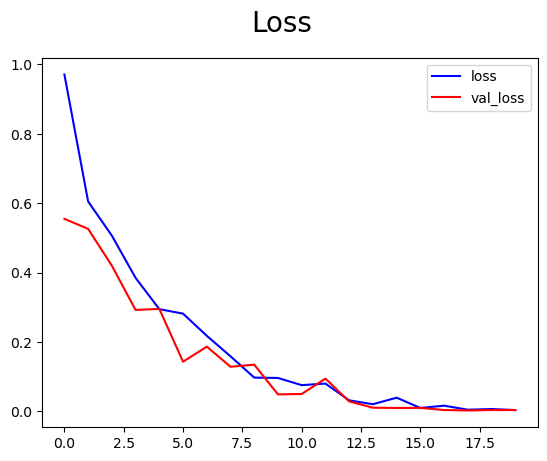

In [99]:
fig = plt.figure()
plt.plot(tmodel.history['loss'], color='blue', label='loss')
plt.plot(tmodel.history['val_loss'], color='red', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")

The model performance is great as there is no overfitting.

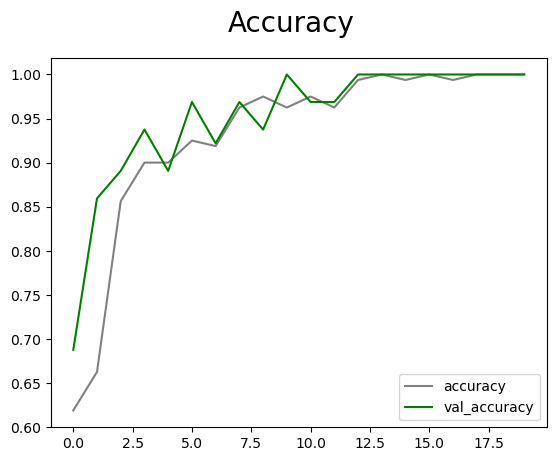

In [100]:
fig = plt.figure()
plt.plot(tmodel.history['accuracy'], color='gray', label='accuracy')
plt.plot(tmodel.history['val_accuracy'], color='green', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")

There is no overfitting too in the accuracy although there is some small spikes in the validation graph.

## 9- Evaluation and testing

In [101]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [102]:
p = Precision()
r = Recall()
acc = BinaryAccuracy()

In [103]:
X, y = batch
predicted_y= model.predict(X)
p.update_state(y, predicted_y)
r.update_state(y, predicted_y)
acc.update_state(y, predicted_y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


In [104]:
print('Precision:',p.result().numpy(),'Recall:', r.result().numpy(),'Accuracy:', acc.result().numpy())

Precision: 1.0 Recall: 1.0 Accuracy: 1.0


## 10- Testing through an external data

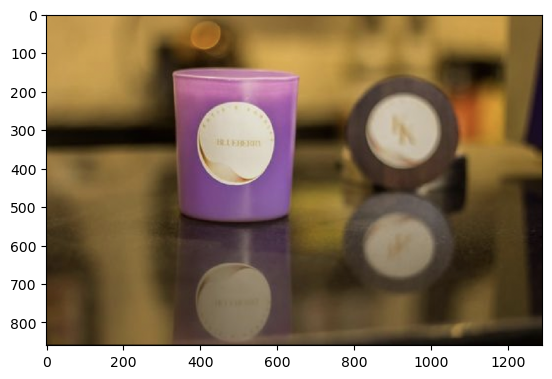

In [107]:
image = cv2.imread('IMG_5215.PNG')
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

In [108]:
resize = tf.image.resize(img, (256,256))
predicted_y = model.predict(np.expand_dims(resize/255, 0))
if predicted_y > 0.5: 
    print('Home Decorations')
else:
    print('Clothes')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Home Decorations


## 11- Saving the model

In [109]:
from tensorflow.keras.models import load_model

In [110]:
model.save(os.path.join('model','slash_image_classifier_model.h5'))